In [1]:
import pandas as pd
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,0,12/31/22,560,manly,20380,1899,0,2,17,37,29,12,2
1,1,12/30/22,559,molar,21204,1973,0,4,21,38,26,9,1
2,2,12/29/22,558,havoc,20001,1919,0,2,16,38,30,12,2
3,3,12/28/22,557,impel,20160,1937,0,3,21,40,25,9,1
4,4,12/27/22,556,condo,20879,2012,0,2,17,35,29,14,3


Text(0.5, 1.0, 'Valid solutions letter frequency')

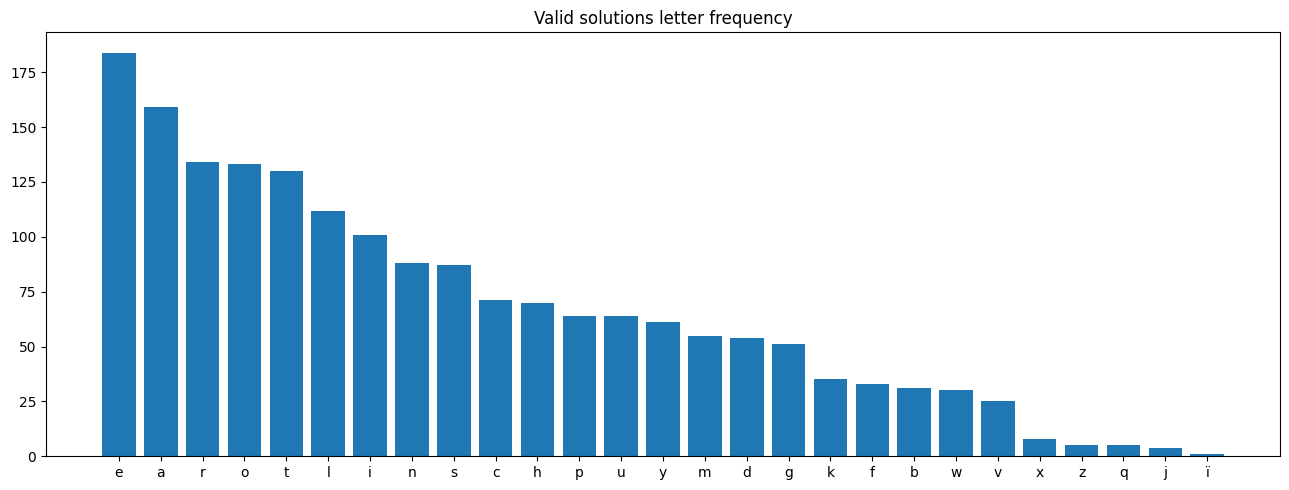

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
word_list = data['Word'].to_list()

# flatten the word list into a list of letters
letter_list = [letter for word in list(word_list) for letter in word]

count = Counter(letter_list)
plt.rc("figure", autolayout=True, figsize=(13, 5))
ax = plt.bar(*zip(*count.most_common()))
plt.title("Valid solutions letter frequency")

In [7]:
import plotly.express as px
import pandas as pd
from collections import Counter

# 读取数据
data = pd.read_csv('data.csv')

# 统计每个字母在单词列表中出现的次数
letter_list = [word[0] for word in data['Word']]
count = Counter(letter_list)

# 将结果转换为 DataFrame 格式，用于绘图
df = pd.DataFrame.from_dict(count, orient='index', columns=['count'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'letter'}, inplace=True)

# 使用 Plotly 绘制柱状图
fig = px.bar(df, x='letter', y='count', color='letter',
             labels={'letter': 'Letter', 'count': 'Count'},
             title='Distribution of First Letters in Words')
fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()


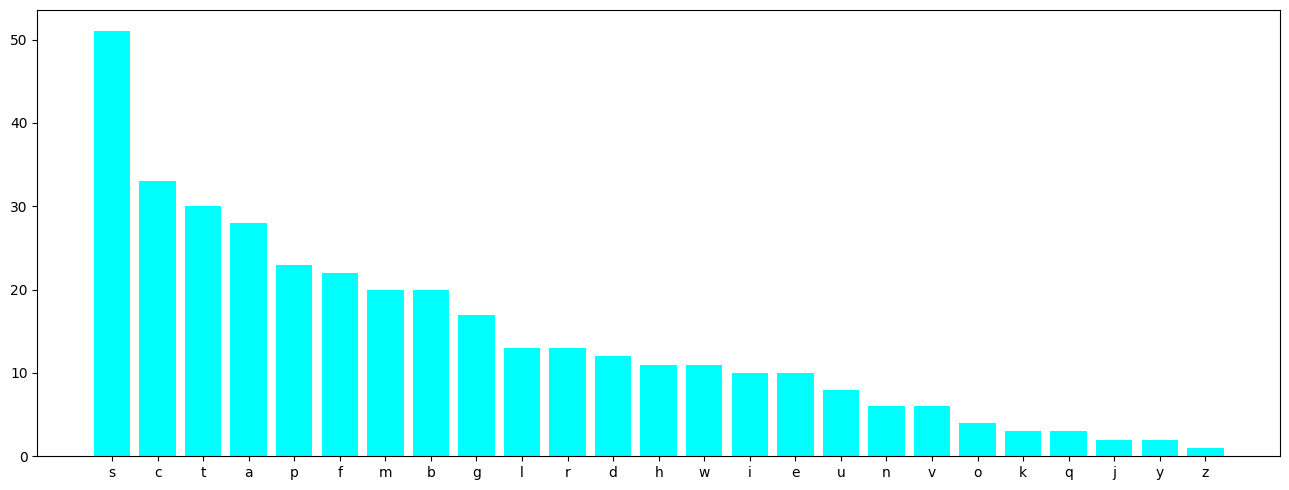

In [4]:
word_list = data['Word'].to_list()

letter_list = [word[0] for word in list(word_list)]

count = Counter(letter_list)
plt.rc("figure", autolayout=True, figsize=(13, 5))
ax = plt.bar(*zip(*count.most_common()), color='aqua')

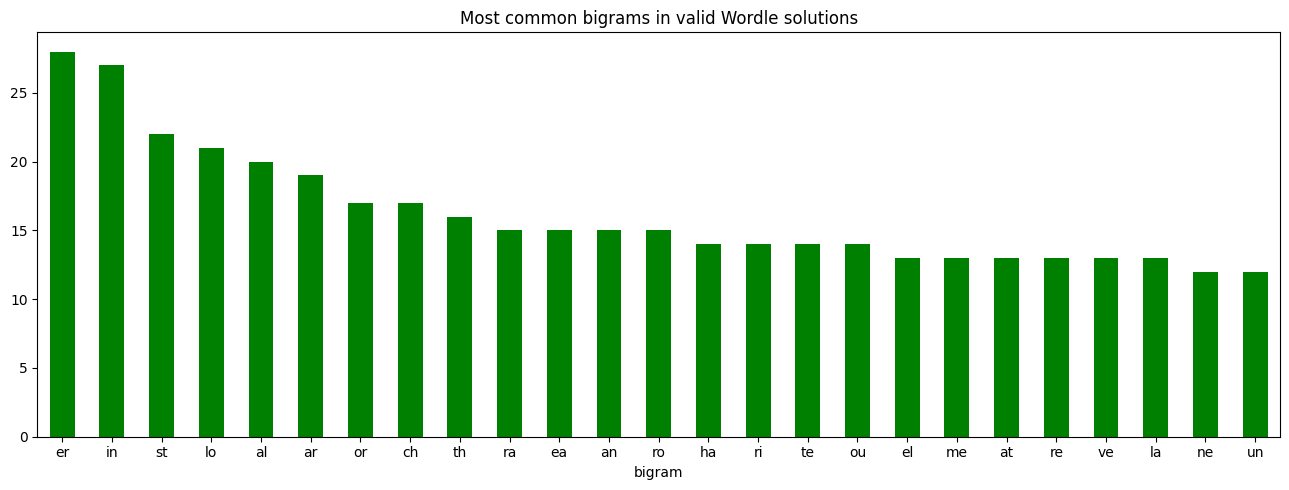

In [8]:
bigrams = Counter()

for word in word_list:
    for idx in range(len(word) - 1):
        bigrams[word[idx : idx + 2]] += 1

bigrams_df = pd.DataFrame({'bigram': bigrams.keys(), 'freq': bigrams.values()})
bigrams_df.sort_values(by='freq', ascending=False, inplace=True)

bigrams_df.head(25).plot.bar(x='bigram', y='freq',
                             rot=0, title="Most common bigrams in valid Wordle solutions",
                             figsize=(13, 5), legend=False, color='green');

In [7]:
# 取出data中的word和date
df = data[['Number of  reported results', 'Date']]
# 將date轉換成datetime格式
df['Date'] = pd.to_datetime(df['Date'])
# 按照date排序
df.sort_values(by='Date', inplace=True)
df.to_csv('ts.csv', index=False)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

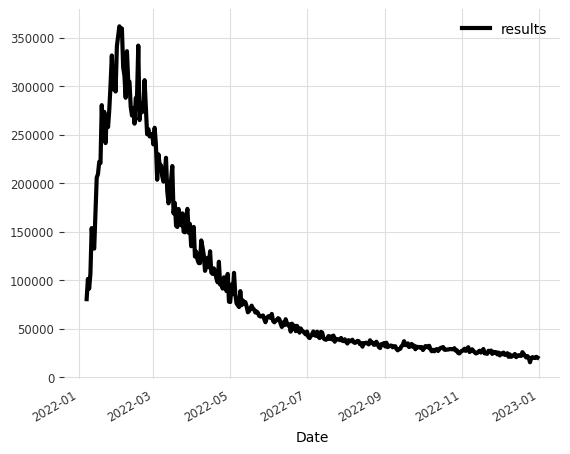

In [14]:
import pandas as pd
df = pd.read_csv('ts.csv', delimiter=",")
series  = TimeSeries.from_dataframe(df, 'Date', 'Number of  reported results')

series.plot(label='results', lw=3)

In [12]:
# 用plotly可视化曲线
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Number of  reported results'],mode='lines',name='results'))
fig.show() 

In [15]:
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("01"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("01"))

In [16]:
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

In [ ]:
my_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

Predicting: 0it [00:00, ?it/s]

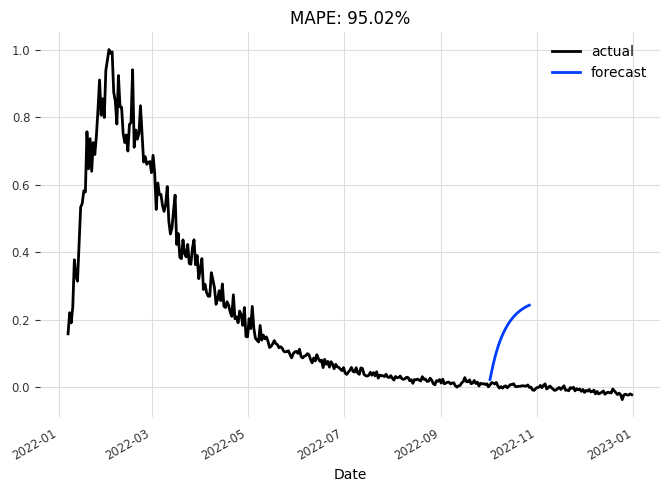

In [18]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()


eval_model(my_model)

In [21]:
ts = series
scaler = Scaler()
ts = scaler.fit_transform(
    ts
)  # scale the whole time series not caring about train/val split...

# We'll use the month as a covariate
month_series = datetime_attribute_timeseries(ts, attribute="month", one_hot=True)
scaler_month = Scaler()
month_series = scaler_month.fit_transform(month_series)

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp("20221001"))
train_month, val_month = month_series.split_after(pd.Timestamp("20221001"))

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset
model_air = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
)

In [ ]:
model_air.fit(
    series=train,
    past_covariates=train_month,
    val_series=val,
    val_past_covariates=val_month,
    verbose=True,
)

In [ ]:
backtest = model_air.historical_forecasts(
    series=ts,
    past_covariates=month_series,
    start=0.7,
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)



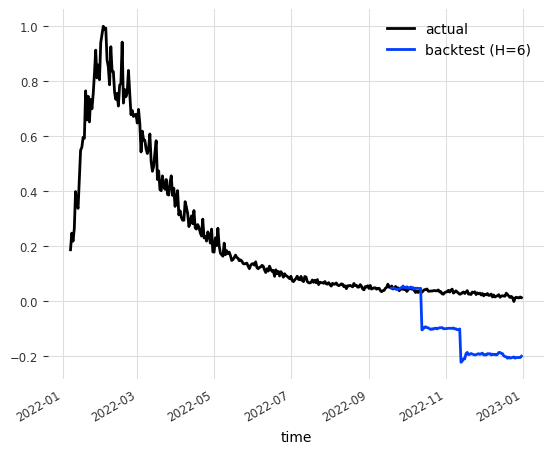

In [26]:
ts.plot(label="actual")
backtest.plot(label="backtest (H=6)")
plt.legend()

In [32]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('data.csv', delimiter=",")
# gama分布拟合
num = df['Number of  reported results'].values
# gamma分布拟合
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt
gamma_fit = gamma.fit(num)
print(gamma_fit)
# gamma分布拟合结果
x = np.linspace(0, num.max(), len(num))
y = gamma.pdf(x, gamma_fit[0], gamma_fit[1], gamma_fit[2])
# 转换日期格式
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
# 使用plotly进行高阶可视化
import plotly.graph_objects as go
fig = go.Figure()
# 填充曲线下方区域

fig.add_trace(go.Scatter(x=df['Date'], y=df['Number of  reported results'],mode='none',fill='tozeroy',name='results'))

fig.add_trace(go.Scatter(x=df['Date'], y=y,mode='lines',name='gamma'))
fig.update_layout(title='Gamma Distribution',xaxis_title='Date',yaxis_title='Number of  reported results')
fig.show()


(0.8348678512557324, 15553.999999999996, 89977.26990986484)


(0.8348669159158597, 15553.999999999998, 89977.29095567395)


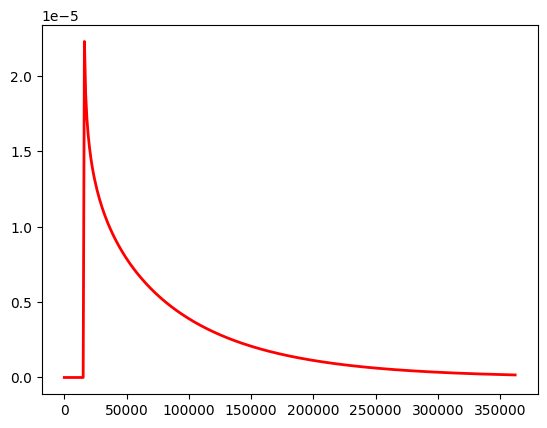

In [12]:
num = df['Number of  reported results'].values
# gamma分布拟合
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt
gamma_fit = gamma.fit(num)
print(gamma_fit)
# gamma分布拟合结果
x = np.linspace(0, num.max(), len(num))
y = gamma.pdf(x, gamma_fit[0], gamma_fit[1], gamma_fit[2])
# 绘制拟合曲线
plt.plot(x, y, 'r-', lw=2)
plt.show()